In [1]:
import pandas as pd
import numpy as np
from csv_cleaner import clean_df

# Chargement des données
df = pd.read_csv('../res/train.csv')

# Nettoyage des données
df = clean_df(df, 100)
df = df.drop(columns=['Model', 'Seats'])
df.head()

,Brand,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,New_Price,Price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,37.24,998.0,58.16,0,1.75
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,0,12.50
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,1,4.50
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,0,6.00
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,0,17.74


C:\Users\GRETA\AppData\Local\Temp\ipykernel_3400\1267108172.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  x = sns.boxplot(data=df['Price'],


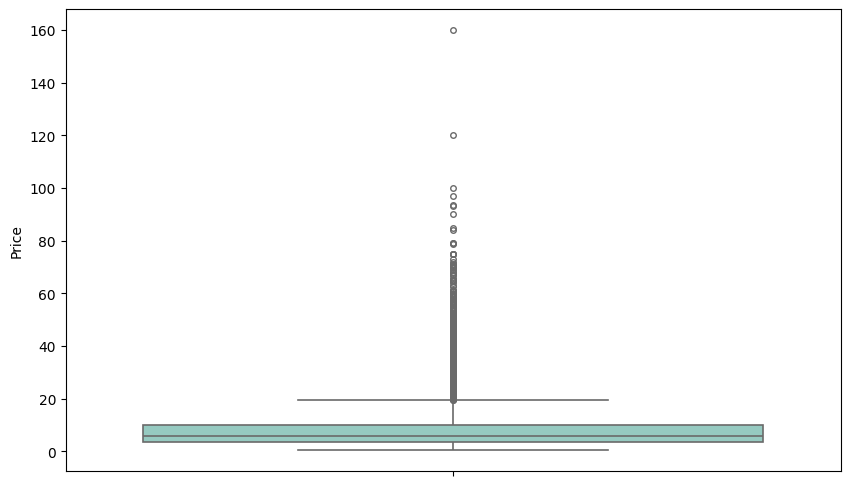

In [2]:
# Création d'une boite à moustache pour supprimer les valeurs abérantes
import matplotlib.pyplot as plt
import seaborn as sns

colonne = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']

fig, ax = plt.subplots(figsize=(10, 6))

x = sns.boxplot(data=df['Price'],
                       palette='Set3',
                       linewidth=1.2,
                       fliersize=2,
                       flierprops=dict(marker='o', markersize=4))


In [3]:
# Calcul de l'IQR
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
borne_inférieure = Q1 - 1.5 * IQR
borne_supérieure = Q3 + 1.5 * IQR

valeurs_aberrantes = df[(df['Price'] < borne_inférieure) | (df['Price'] > borne_supérieure)]
nombre_valeurs_aberrantes = len(valeurs_aberrantes)
print(nombre_valeurs_aberrantes)


718


In [4]:
# Calcul de la moyenne
mean_price = df['Price'].mean()
# Calcul de l'écart-type
std_price = df['Price'].std()

# Calcul du Z-score pour chaque observation dans la colonne 'Price'
df['Price_Z_score'] = (df['Price'] - mean_price) / std_price

df['Price_Z_score']

print(len(df['Price']))

# Supprimer les lignes contenant des valeurs aberrantes
df['Price'] = df[abs(df['Price_Z_score']) <= 3]

# Afficher le nombre de lignes restantes dans le DataFrame
print(len(df['Price']))


149


In [5]:
# Séparation des données en apprentissage et test
from sklearn.model_selection import train_test_split

X = df.drop(columns= ['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor as GBR
from pipeline_GBR import pipeline_create


# Mettre à jour la grille de paramètres pour cibler directement GradientBoostingRegressor au sein du pipeline
param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__max_depth': [3, 5, 7],
    'gradientboostingregressor__min_samples_split': [2, 4],
    'gradientboostingregressor__min_samples_leaf': [1, 3],
    'gradientboostingregressor__max_features': ['sqrt'],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0]
}

# Construire le pipeline avec GradientBoostingRegressor comme 'regressor'
pipeline = pipeline_create(X_train, GBR(random_state=0))

# Appliquer GridSearchCV sur le pipeline au lieu de juste le modèle
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Year',
                                                                          'Kilometers_Driven',
                                                                          'Mileage',
                                                                          'Engine',
                                                                          'Power',
                                                                          'New_Price',
                                                                          'Price_Z_score']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         (...
             param_grid={'gradientboostingregressor__max_depth': [3, 5, 7],
                         'gradientboostingregressor__max_features': ['sqrt'],
                         'gradientboostingregressor__min_samples_leaf': [1, 3],
                         'gradientboostingregressor__min_samples_split': [2, 4],
                         'gradientboostingregressor__n_estimators': [100, 200,
                                                                     300],
                         'gradientboostingregressor__subsample': [0.8, 0.9,
                                                                  1.0]},
             scoring='neg_mean_squared_error')

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

# Configuration de KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Initialiser des listes pour enregistrer les scores pour chaque pli
mse_scores = []
rmse_scores = []
r2_scores = []

# Boucler sur chaque pli défini par KFold
for train_index, test_index in kf.split(X):

    # On redéfini les données d'apprentissage et de test pour chaque pli
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    # Calcul du MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    # Calcul du RMSE
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
    
    # Calcul du R2
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

print(f"MSE : {mse_scores}")
print(f"RMSE : {rmse_scores}")
print(f"R² : {r2_scores}")

print("Mean MSE:", np.mean(mse_scores))
print("Mean RMSE:", np.mean(rmse_scores))
print("Mean R²:", np.mean(r2_scores))

In [ ]:
# Enregistrement du modèle

# import pickle

# #Chemin où vous souhaitez enregistrer le modèle
# chemin_fichier = 'GBR.pkl'

# with open(chemin_fichier, 'wb') as fichier:
#     pickle.dump(pipeline, fichier)

# print(f"Modèle enregistré avec succès dans {chemin_fichier}")


Modèle enregistré avec succès dans GBR.pkl


In [ ]:
#Utilsation du modèle
# import pickle

# with open('GBR.pkl', 'rb') as fichier:
#     GBR = pickle.load(fichier)

# donnees_de_test = pd.read_csv('../res/clean_train.csv')
# predictions = GBR.predict(donnees_de_test)

# print(predictions)
# print(len(predictions))